For fine-tuning we have 3 datasets: train, validation and holdout

In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn

from scipy.ndimage.interpolation import zoom
from sklearn.utils import shuffle
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import os
import time
import h5py

# keras
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import Sequence
import keras.backend as K

from config import *
from utils import specificity, sensitivity, balanced_accuracy, IntensityRescale, sagittal_flip, translate, load_nifti

Using TensorFlow backend.


In [2]:
# Start timing
start_time = time.time()

In [3]:
#percent = 0.5
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session


config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = percent
config.gpu_options.visible_device_list = "3"
set_session(tf.Session(config=config))

In [4]:
zero_one_normalize = True
dtype = np.float32
z_factor = 0.525
result_dir = "/analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred/"

In [5]:
!mkdir -p $result_dir

In [6]:
# load hdf5 files and extract columns
train_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/train_dataset.h5', 'r')
holdout_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/holdout_dataset.h5', 'r')

X_train, y_train = train_h5['X'], train_h5['y']
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

In [7]:
# convert data to numpy arrays
X_train = np.array(X_train, dtype=dtype)
y_train = np.array(y_train)

X_holdout = np.array(X_holdout, dtype=dtype)
y_holdout = np.array(y_holdout)

In [8]:
print("Total datset length: {}".format(len(y_train)))
print("Number of healthy controls: {}".format(len(np.array(y_train)[np.array(y_train)==0.])))
print("Number of MS patients: {}".format(len(np.array(y_train)[np.array(y_train)==1.])))

Total datset length: 124
Number of healthy controls: 61
Number of MS patients: 63


In [9]:
class CISDataset(Sequence):
    def __init__(self, X, y, transform=None, batch_size=4, z_factor=None, shuffle=True, mask=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.batch_size = batch_size
        self.z_factor = z_factor
        self.shuffle = shuffle
        self.mask = mask
        
    def __len__(self):
        return int(np.ceil(len(self.y)/self.batch_size))
    
    def __getitem__(self, idx):
        # add BET
        image = np.expand_dims(self.X[idx * self.batch_size:(idx + 1) * self.batch_size],5)
        #label = np.array((batch_idx['label'] == "MS")* 1, dtype=np.int8) 
        label = np.array(self.y[idx * self.batch_size:(idx + 1) * self.batch_size], dtype=np.int8)
        
        if self.mask is not None:
            for i in range(image.shape[0]):
                image[i] *= self.mask
        
        for transformation in self.transform:
            image = transformation(image)
        
        return image, label
    
    def on_epoch_end(self):
        if self.shuffle:
            self.X, self.y = shuffle(self.X, self.y)

## Load mask and reformat

In [10]:
mask_path = "/data/Ritter/MS/Test/total_lesion_mask_blurred.nii.gz"

In [11]:
mask = load_nifti(mask_path, z_factor=z_factor)
mask = np.expand_dims(mask, 4)

/home/fabiane/.local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


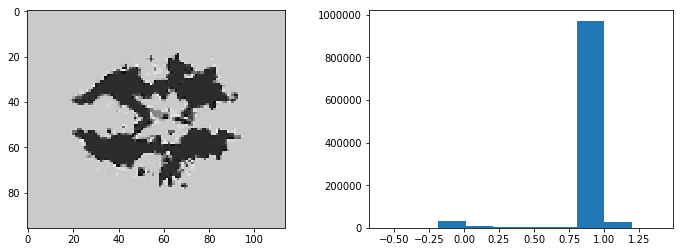

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(mask[:,:,48, 0], cmap='gray')
plt.subplot(1, 2, 2)
plt.hist(mask.flatten())
plt.show()

In [13]:
# after zooming return to binary format
mask[np.where(mask>0.5)] = 1.
mask[np.where(mask<=0.5)] = 0.

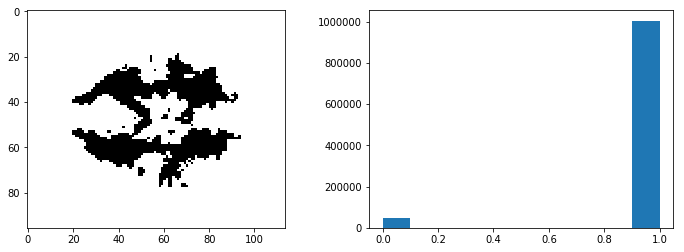

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(mask[:,:,48, 0], cmap='gray')
plt.subplot(1, 2, 2)
plt.hist(mask.flatten())
plt.show()

## Make dataset

In [15]:
intensity = IntensityRescale(masked=False)

In [16]:
if zero_one_normalize:
    cis_data = CISDataset(X_train, y_train, transform=[intensity], batch_size=4, mask=mask)
else:
    cis_data = CISDataset(X_train, y_train, batch_size=4, mask=mask)

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


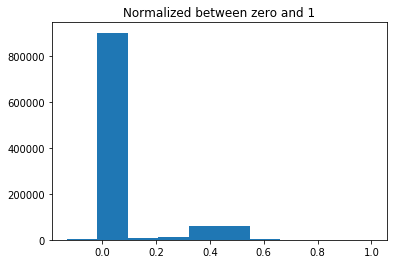

In [17]:
plt.figure()
plt.title("Normalized between zero and 1")
plt.hist(cis_data[4][0][0].flatten())
plt.show()

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


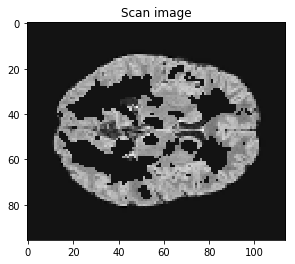

In [18]:
plt.figure()
plt.title("Scan image")
plt.imshow(np.squeeze(cis_data[4][0][0])[:,:,42], cmap='gray')
plt.show()

# Model

In [19]:
def init_model(path, finetune=True, up_to=7):
    model = load_model(path)
    model.load_weights(path)
    if finetune:
        for layer in model.layers[:up_to]:
            layer.trainable = False
    return model

In [20]:
# load model weights
model_path = "/analysis/share/Ritter/models/fabi/ADNI/pretraining_paper/model.h5"
model = init_model(model_path, finetune=False, up_to=None)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv3D)              (None, 94, 112, 94, 64)   1792      
_________________________________________________________________
Pool_1 (MaxPooling3D)        (None, 31, 37, 31, 64)    0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 31, 37, 31, 64)    0         
_________________________________________________________________
Conv_2 (Conv3D)              (None, 29, 35, 29, 64)    110656    
_________________________________________________________________
Pool_2 (MaxPooling3D)        (None, 9, 11, 9, 64)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 9, 11, 9, 64)      0         
_________________________________________________________________
Conv_3 (Conv3D)              (None, 7, 9, 7, 64)       110656    
__________

## Visualization

In [21]:
def visualize_weights(model):
    # Visualize weights
    W = model.layers[0].get_weights()[0]
    W = np.squeeze(W)[:,:,2]
    print("W shape : ", W.shape)

    print("Weights mean {}".format(W.mean()))
    plt.figure(figsize=(20, 5))
    plt.title('conv1 weights')
    plt.imshow(make_mosaic(W, 2, 2), cmap="gray")
    plt.show()

In [22]:
import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

In [23]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)


Pre-trained model layer 1 weights:
W shape :  (3, 3, 64)
Weights mean -0.003789090784266591


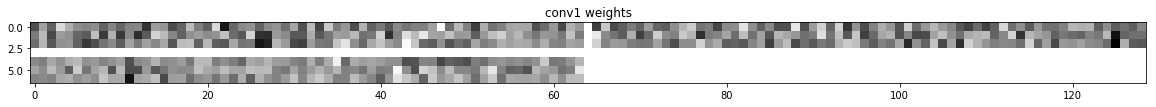

Random model layer 1 weights:
W shape :  (3, 3, 64)
Weights mean -0.0010208189487457275


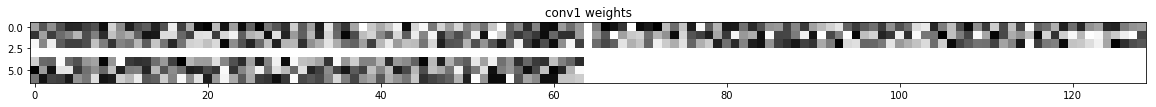

In [24]:
# Visualize weights
print("Pre-trained model layer 1 weights:")
visualize_weights(model)
model_untrained = load_model(model_path)
reset_weights(model_untrained)
print("Random model layer 1 weights:")
visualize_weights(model_untrained)

## Training

In [25]:
X_train.shape

(124, 96, 114, 96)

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
# split training set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=77)

In [28]:
# training args
lr = 0.0005
lr_decay = 0.001
transforms = [intensity, sagittal_flip, translate]

num_trials = 7
store_models = True

# callbacks
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

accuracies = []
balanced_accuracies = []
max_acc = []

for i in range(num_trials):
    print("Trial %i" %i)
    
    # init model
    model = init_model(model_path, finetune=False, up_to=None)    
    opti = Adam(lr=lr, decay=lr_decay)
    model.compile(optimizer=opti, loss='binary_crossentropy', metrics=['accuracy'])
    
    # callbacks
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
    if store_models:
        result_path = os.path.join(result_dir, "weights-augm-trial%i-improvement-BEST.hdf5" %i)
        model_checkpoint = ModelCheckpoint(result_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
        callbacks = [earlystop, model_checkpoint]
    else:
        callbacks = [earlystop]
        
    train_loader = CISDataset(X_train, y_train, transform=transforms, batch_size=b, shuffle=True, mask=mask)
    val_loader = CISDataset(X_val, y_val, transform=[intensity], batch_size=1, shuffle=False, mask=mask)
    
    # Start training
    history = model.fit_generator(train_loader,
                        epochs=num_epochs,
                        verbose=1,
                        validation_data=val_loader,
                        callbacks=callbacks)
    
    # Evaluation
    y_pred = model.predict_generator(val_loader)
    #y_true = [item for sublist in [val_loader[batch_idx][1] for batch_idx in range(len(val_loader))] for item in sublist]
    bal_acc = balanced_accuracy(y_val, y_pred>0.5)
    accuracies.append(history.history["val_acc"][-1])
    balanced_accuracies.append(bal_acc)
    max_acc.append(np.max(history.history["val_acc"]))

training_time = time.time() - start_time
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))

print("Validation final accuracies: \n {}".format(accuracies))
print("Validation final accuracies mean: {}".format(np.mean(accuracies)))
print("Validation best accuracies: \n {}".format(max_acc))
print("Validation best accuracies mean: {}".format(np.mean(max_acc)))
print("Validation balanced accuracies: \n {}".format(balanced_accuracies))
print("Validation balanced accuracies mean: {}".format(np.mean(balanced_accuracies)))



Trial 0
Epoch 1/200


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


25/25 [==============================] - 7s 299ms/step - loss: 0.9631 - acc: 0.4834 - val_loss: 0.8631 - val_acc: 0.4400

Epoch 00001: val_acc improved from -inf to 0.44000, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred/weights-augm-trial0-improvement-BEST.hdf5
Epoch 2/200
25/25 [==============================] - 4s 158ms/step - loss: 0.9097 - acc: 0.5234 - val_loss: 0.8396 - val_acc: 0.5600

Epoch 00002: val_acc improved from 0.44000 to 0.56000, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred/weights-augm-trial0-improvement-BEST.hdf5
Epoch 3/200
25/25 [==============================] - 4s 158ms/step - loss: 0.8942 - acc: 0.4902 - val_loss: 0.8578 - val_acc: 0.4400

Epoch 00003: val_acc did not improve from 0.56000
Epoch 4/200
25/25 [==============================] - 4s 159ms/step - loss: 0.9201 - acc: 0.4834 - val_loss: 0.8186 - val_acc: 0.4800

Epoch 00004: val_acc did no

25/25 [==============================] - 5s 203ms/step - loss: 0.9736 - acc: 0.5502 - val_loss: 0.8517 - val_acc: 0.6000

Epoch 00001: val_acc improved from -inf to 0.60000, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred/weights-augm-trial2-improvement-BEST.hdf5
Epoch 2/200
25/25 [==============================] - 4s 159ms/step - loss: 0.9076 - acc: 0.4966 - val_loss: 0.8353 - val_acc: 0.5600

Epoch 00002: val_acc did not improve from 0.60000
Epoch 3/200
25/25 [==============================] - 4s 160ms/step - loss: 0.8896 - acc: 0.5134 - val_loss: 0.8850 - val_acc: 0.4400

Epoch 00003: val_acc did not improve from 0.60000
Epoch 4/200
25/25 [==============================] - 4s 157ms/step - loss: 0.9784 - acc: 0.4134 - val_loss: 0.8284 - val_acc: 0.4400

Epoch 00004: val_acc did not improve from 0.60000
Epoch 5/200
25/25 [==============================] - 4s 158ms/step - loss: 0.9201 - acc: 0.3733 - val_loss: 0.7968 - val_acc: 0.

25/25 [==============================] - 4s 158ms/step - loss: 0.6211 - acc: 0.7535 - val_loss: 0.6286 - val_acc: 0.6800

Epoch 00041: val_acc did not improve from 0.92000
Epoch 42/200
25/25 [==============================] - 4s 160ms/step - loss: 0.6812 - acc: 0.6867 - val_loss: 0.5980 - val_acc: 0.7200

Epoch 00042: val_acc did not improve from 0.92000
Epoch 00042: early stopping
Trial 3
Epoch 1/200
25/25 [==============================] - 5s 210ms/step - loss: 0.9854 - acc: 0.4534 - val_loss: 0.8522 - val_acc: 0.5600

Epoch 00001: val_acc improved from -inf to 0.56000, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred/weights-augm-trial3-improvement-BEST.hdf5
Epoch 2/200
25/25 [==============================] - 4s 158ms/step - loss: 1.0091 - acc: 0.4534 - val_loss: 0.8434 - val_acc: 0.4800

Epoch 00002: val_acc did not improve from 0.56000
Epoch 3/200
25/25 [==============================] - 6s 244ms/step - loss: 0.8625 - acc: 0.

25/25 [==============================] - 4s 159ms/step - loss: 0.8120 - acc: 0.4966 - val_loss: 0.8250 - val_acc: 0.4400

Epoch 00011: val_acc did not improve from 0.56000
Epoch 12/200
25/25 [==============================] - 4s 159ms/step - loss: 0.8618 - acc: 0.5198 - val_loss: 0.8323 - val_acc: 0.4400

Epoch 00012: val_acc did not improve from 0.56000
Epoch 00012: early stopping
Trial 5
Epoch 1/200
25/25 [==============================] - 6s 226ms/step - loss: 0.9463 - acc: 0.5334 - val_loss: 0.8503 - val_acc: 0.5600

Epoch 00001: val_acc improved from -inf to 0.56000, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred/weights-augm-trial5-improvement-BEST.hdf5
Epoch 2/200
25/25 [==============================] - 4s 159ms/step - loss: 1.0137 - acc: 0.3333 - val_loss: 0.8329 - val_acc: 0.5600

Epoch 00002: val_acc did not improve from 0.56000
Epoch 3/200
25/25 [==============================] - 4s 161ms/step - loss: 0.9527 - acc: 0.

25/25 [==============================] - 4s 161ms/step - loss: 0.6324 - acc: 0.7299 - val_loss: 0.6587 - val_acc: 0.8000

Epoch 00039: val_acc did not improve from 0.80000
Epoch 40/200
25/25 [==============================] - 4s 162ms/step - loss: 0.6482 - acc: 0.6935 - val_loss: 0.7258 - val_acc: 0.5600

Epoch 00040: val_acc did not improve from 0.80000
Epoch 41/200
25/25 [==============================] - 4s 161ms/step - loss: 0.6470 - acc: 0.7067 - val_loss: 0.6451 - val_acc: 0.7600

Epoch 00041: val_acc did not improve from 0.80000
Epoch 00041: early stopping
Trial 6
Epoch 1/200
25/25 [==============================] - 6s 234ms/step - loss: 1.0218 - acc: 0.4534 - val_loss: 0.8631 - val_acc: 0.4400

Epoch 00001: val_acc improved from -inf to 0.44000, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred/weights-augm-trial6-improvement-BEST.hdf5
Epoch 2/200
25/25 [==============================] - 4s 162ms/step - loss: 0.9343 - acc: 0

In [29]:
training_time = time.time() - start_time

# Evaluation

In [30]:
weights = ["weights-augm-trial0-improvement-BEST.hdf5",
           "weights-augm-trial1-improvement-BEST.hdf5",
           "weights-augm-trial2-improvement-BEST.hdf5",
           "weights-augm-trial3-improvement-BEST.hdf5",
           "weights-augm-trial4-improvement-BEST.hdf5",
           "weights-augm-trial5-improvement-BEST.hdf5",
           "weights-augm-trial6-improvement-BEST.hdf5",
          ]

In [31]:
# load holdout set
test_loader = CISDataset(X_holdout, y_holdout, transform=[intensity], batch_size=1, shuffle=False, mask=mask)

In [32]:
accuracies = []
balanced_accuracies = []
for fold, weight in enumerate(weights):
    print("Fold {}".format(fold))
    model = load_model(model_path)
    model_dir = os.path.join(result_dir, weight)
    model.load_weights(model_dir)
    
    opti = Adam(lr=lr, decay=lr_decay)
    model.compile(optimizer=opti,
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    res = model.evaluate_generator(test_loader)
    print("Model accuracy {:.2f} %".format(res[1]*100))
    
    y_pred = (model.predict_generator(test_loader) > 0.5) * 1
    bal_acc = balanced_accuracy(y_holdout, y_pred)
    print("Balanced accuracy {:.2f} %".format(bal_acc*100))
    
    accuracies.append(res[1])
    balanced_accuracies.append(bal_acc)
print("######## Final results ########")
print("Accuracy mean {:.2f} %".format(np.mean(accuracies)*100))
print("Balanced accuracy mean {:.2f} %".format(np.mean(balanced_accuracies)*100))

Fold 0


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 52.17 %
Balanced accuracy 51.92 %
Fold 1
Model accuracy 47.83 %
Balanced accuracy 52.69 %
Fold 2
Model accuracy 69.57 %
Balanced accuracy 66.15 %
Fold 3
Model accuracy 56.52 %
Balanced accuracy 55.77 %
Fold 4
Model accuracy 43.48 %
Balanced accuracy 50.00 %
Fold 5
Model accuracy 78.26 %
Balanced accuracy 76.15 %
Fold 6
Model accuracy 56.52 %
Balanced accuracy 50.00 %
######## Final results ########
Accuracy mean 57.76 %
Balanced accuracy mean 57.53 %


In [33]:
total_time = time.time() - start_time

In [34]:
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))
print("Total time elapsed: {}h:{}m:{}s".format(
            total_time//3600, (total_time//60)%60, total_time%60))

Training Time: 0.0h:12.0m:42.642473459243774s
Total time elapsed: 0.0h:13.0m:29.874017000198364s


In [35]:
quit()